# Spikes and Bursts Detection, Classification, and Visualization

This workflow processes electrophysiological recordings stored in ABF format. It includes:

- Loading and concatenating multiple sweeps into a single continuous signal.

- Detecting spikes using a voltage threshold.

- Identifying bursts based on short inter-spike intervals (ISIs).

- Classifying bursts by waveform shape (square-wave, parabolic, or other).

- Saving the results to a CSV file.

- Visualizing the raw signal with spikes and bursts highlighted.



os: Interact with the filesystem and list .abf files.

pyabf: Load ABF files containing membrane potential recordings.

numpy / pandas: Handle arrays and DataFrames for organizing data.

scipy.stats: Compute skewness and kurtosis of voltage segments.

scipy.signal:

find_peaks detects voltage peaks (spikes).

hilbert computes the signal envelope for symmetry analysis.

numpy.linalg.lstsq / r2_score: Fit parabolas to bursts and measure goodness-of-fit.

UMAP and StandardScaler: Dimensionality reduction for segment clustering and visualization.

scipy.spatial.distance / NearestNeighbors: Compute distances between burst centroids and detect conflict regions.

matplotlib / seaborn / plotly / dash: Visualization and interactive dashboard components.

In [ ]:
# Libraries
import os                          # For interacting with the operating system (listing files, joining paths)
import pyabf                       # For reading ABF (Axon Binary Format) electrophysiology files
import numpy as np                  # Numerical operations, arrays, linear algebra
import pandas as pd                 # Data manipulation and DataFrame structures
from scipy.stats import skew, kurtosis  # For computing skewness and kurtosis
from scipy.signal import find_peaks, hilbert  # For spike detection and Hilbert transform
from numpy.linalg import lstsq      # Linear least squares fitting
from sklearn.metrics import r2_score    # To evaluate goodness-of-fit
from sklearn.preprocessing import StandardScaler  # Standardize features for UMAP
import umap                         # UMAP for dimensionality reduction

from scipy.spatial import distance  # To compute distances between points or centroids
from sklearn.neighbors import NearestNeighbors  # To find nearest neighbors for conflict detection

import matplotlib.pyplot as plt     # Plotting library
import seaborn as sns               # Statistical data visualization
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})  # Set default Seaborn style

from dash import Dash, dcc, html, Input, Output  # Interactive dashboard components
import plotly.express as px         # Easy plotting for Dash
import plotly.graph_objects as go   # Detailed Plotly graphing
import plotly.io as pio
pio.renderers.default = "browser"   # Open plots in the default browser

- **Analysis Parameters**

folder_path: Folder containing ABF files to process.

threshold: Minimum voltage to detect a spike.

burst_threshold: Maximum interval between spikes to consider them part of the same burst.

fs / dt: Sampling frequency and sampling period.

min_spikes_in_burst: Minimum number of spikes required to define a burst.

all_segment_metrics / all_segment_traces: Lists to store metrics and voltage traces for all segments.

abf_files: List of ABF files in the folder.

In [ ]:
# 1. Parameters
folder_path = "bursting"           # Folder containing ABF files
threshold = -35                    # Voltage threshold (mV) to detect spikes
burst_threshold = 0.3              # Maximum inter-spike interval (seconds) for a burst
fs = 10000                         # Sampling frequency in Hz
dt = 1/fs                           # Sampling period (s)
min_spikes_in_burst = 4            # Minimum spikes to define a burst

# Lists to store results across all files and sweeps
all_segment_metrics = []           # Will hold computed metrics for each segment
all_segment_traces = []            # Will store voltage traces of each segment

# List all ABF files in the folder
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

 **ABF Processing: Spike and burst detection and classification**
- **Load Files and Sweeps:**

Loops over all ABF files in the folder.

pyabf.ABF(file_path) loads an ABF file.

Loops over each sweep (repeated recording within the same file).

time and voltage are arrays of time points and voltages for the sweep.


- **Spike Detection:**

Detects peaks above the voltage threshold.

Converts spike indices to seconds using the sampling frequency.

This forms the basis for detecting bursts and calculating ISI (inter-spike intervals).


- **Burst Detection:**

Calculates ISI (difference between consecutive spikes).

Spikes with ISI below burst_threshold are considered part of the same burst.

Only saves bursts with at least min_spikes_in_burst spikes.

Result: list of tuples (start, end) for each burst.


- **Segment Creation:**

Converts the recording into labeled segments:

"Burst": intervals with bursts.

"Non-burst": intervals between bursts or the whole sweep if no bursts exist.

Allows computing metrics separately for each segment type.

- **Burst Classification:**

For each burst:

Calculate minimum voltage and mean voltage of neighboring non-burst segments.

Fit a parabola to the burst and compute R² to assess shape.

Compute symmetry using the Hilbert envelope.

Classify burst:

Square Wave: min > baseline mean → flat shape.

Parabolic: min < baseline mean → curved shape.

Other: ambiguous or irregular.


- **Segment Metrics Computation:**

For each segment (burst or non-burst), calculates:

Duration, number of spikes, and mean ISI.

Basic statistics: mean, std, min, max, skewness, kurtosis, area under curve.

Derivative statistics: mean, std, min, max, skewness, kurtosis of voltage changes.

Saves metrics and traces.

In [ ]:
# 2. ABF Processing
for file_name in abf_files:                     # Loop over each ABF file
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)                  # Load ABF file

    for sweep in range(abf.sweepCount):        # Loop over sweeps in ABF file
        abf.setSweep(sweep)                    # Set the current sweep
        time = abf.sweepX                      # Time array
        voltage = abf.sweepY                   # Voltage array

        
        # Spike detection
        peaks, _ = find_peaks(voltage, height=threshold)  # Find voltage peaks above threshold
        spike_times = peaks / fs                           # Convert peak indices to seconds

        
        # Burst detection
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)                     # Compute inter-spike intervals
            current_burst = [spike_times[0]]              # Initialize first potential burst
            for i in range(1, len(spike_times)):
                if isi[i-1] < burst_threshold:            # ISI below threshold => same burst
                    current_burst.append(spike_times[i])
                else:
                    if len(current_burst) >= min_spikes_in_burst:  # Only save burst if enough spikes
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]      # Start new burst
            # Add last burst if it has enough spikes
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))


        # Segment creation (burst vs non-burst)
        segments = []
        for start, end in bursts:                         # Add burst segments
            segments.append((start, end, "Burst"))
        if bursts:
            # Add non-burst segments before first burst
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            # Add non-burst segments between bursts
            for i in range(len(bursts)-1):
                segments.append((bursts[i][1], bursts[i+1][0], "Non-burst"))
            # Add non-burst segment after last burst
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            # No bursts detected: whole sweep is non-burst
            segments.append((time[0], time[-1], "Non-burst"))

        
        # Burst classification
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                # Extract voltage segment
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # Estimate mean voltage of neighboring non-burst segments
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i-1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments)-1:
                    next_start = segments[i+1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])  # Mean of neighboring regions

                # Minimum voltage inside the burst
                burst_min = np.min(seg_voltage)

                # Fit a 2nd-degree polynomial (parabola) to the burst for shape assessment
                t_fit = np.linspace(-0.5, 0.5, len(seg_voltage))
                X = np.vstack([t_fit**2, t_fit, np.ones_like(t_fit)]).T
                coef, *_ = lstsq(X, seg_voltage, rcond=None)
                y_hat = X @ coef
                r2_parabola = r2_score(seg_voltage, y_hat)  # Goodness of fit

                # Compute symmetry using Hilbert envelope
                analytic_signal = hilbert(seg_voltage)
                envelope = np.abs(analytic_signal)
                half = len(envelope)//2
                symmetry = (np.corrcoef(envelope[:half], envelope[-half:][::-1])[0,1]
                            if half>=2 else np.nan)

                # Spike rate inside the burst
                seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
                spike_rate = len(seg_peaks)/(seg_end - seg_start)

                # Classify burst type based on min voltage vs neighboring mean
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                # Non-burst segments
                burst_type = "Non-burst"

            burst_types.append(burst_type)


        # Segment metrics computation
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]

            duration = seg_end - seg_start        # Segment duration
            burst_type = burst_types[j]           # Already classified burst type

            # Recalculate peaks and ISI
            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks/fs)) if num_peaks>=2 else 0

            # Basic statistics
            if len(seg_voltage)<2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)  # Area under curve

            # Derivative-based statistics
            if len(seg_voltage)<2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage)/dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            # Save metrics and voltage traces
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])
            all_segment_traces.append(seg_voltage.tolist())

- **Save Processed Data:**

Creates a DataFrame with all metrics.

Saves CSV and .npy file for later analysis.

In [ ]:
# 3. Save CSV and voltage traces
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurt_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)
np.save("segment_traces.npy", np.array(all_segment_traces, dtype=object))

- **Dimensionality Reduction with UMAP:**

Selects all metrics as features.

Standardizes features and reduces dimensionality to 2D using UMAP.

Combines embeddings with metadata (burst type and index).

- **Conflict Detection Between Burst Types:**

Computes centroids of each burst type in UMAP space.

Detects types that are too close / overlapping.

Uses nearest neighbors to identify individual points in conflict regions.

- **Visualize Conflicts:**

Plots UMAP scatter of all segments colored by burst type.

Red points highlight regions of potential classification conflict.

In [ ]:
# 4. UMAP dimensionality reduction
header = list(df_segments)[4:]              # Features used for UMAP
X = np.array(df_segments[header])
y = np.array(df_segments.Burst_Type)

# Standardize data and fit UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Combine UMAP embedding with metadata
df_umap = pd.DataFrame(embedding, columns=["UMAP1","UMAP2"])
df_umap["Burst_Type"] = y
df_umap["id"] = np.arange(len(df_umap))


# 4b. Burst type conflicts detection
df_umap["Index"] = df_segments.index

# Compute centroids of each burst type
centroids = df_umap.groupby("Burst_Type")[["UMAP1","UMAP2"]].mean()
dist_matrix = distance.cdist(centroids.values, centroids.values)  # Pairwise distances
dist_df = pd.DataFrame(dist_matrix, index=centroids.index, columns=centroids.index)
print("\nDistance between centroids of burst types:")
print(dist_df)

# Compute threshold to detect potential overlaps
threshold = np.percentile(dist_matrix[dist_matrix>0], 10)
print(f"\nOverlap threshold (UMAP distance): {threshold:.3f}")

# Identify pairs of burst types that are too close
close_pairs = []
for i, type_i in enumerate(centroids.index):
    for j, type_j in enumerate(centroids.index):
        if j>i and dist_matrix[i,j]<threshold:
            close_pairs.append((type_i,type_j))
print("\nPotentially overlapping burst type pairs:")
print(close_pairs)


# Conflict points detection using nearest neighbors
X_umap = df_umap[["UMAP1","UMAP2"]].values
labels = df_umap["Burst_Type"].values
nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):  # If neighbors have different type, mark as conflict
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Extract conflicting segments
conflicts_df = df_segments.iloc[conflict_indices]
print(f"\nNumber of segments in conflict regions: {len(conflicts_df)}")
print(conflicts_df.groupby("Burst_Type").size())

# Visualize conflict regions in UMAP
plt.figure(figsize=(10,7))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Burst_Type", alpha=0.4, palette="tab10")
sns.scatterplot(data=df_umap.iloc[conflict_indices], x="UMAP1", y="UMAP2", color="red", s=50, label="Conflicts", alpha=0.8)
plt.legend()
plt.title("Conflict regions between burst classes")
plt.show()

- **Interactive Dashboard with Dash:**

Creates an interactive dashboard:

UMAP plot: shows all segments colored by burst type.

Timeseries viewer: displays voltage trace of a segment when clicked.

Enables interactive exploration of individual bursts and their waveform shapes.

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipykernel_18624\2991793300.py:116: RuntimeWarning:

Mean of empty slice

C:\Users\manur\AppData\Local\Temp\ipy


Distance between centroids of burst types:
Burst_Type   Non-burst     Other  Parabolic  Square Wave
Burst_Type                                              
Non-burst     0.000000  6.298329   6.489494     9.508167
Other         6.298329  0.000000   4.686298     3.212923
Parabolic     6.489494  4.686298   0.000000     6.379337
Square Wave   9.508167  3.212923   6.379337     0.000000

Overlap threshold (UMAP distance): 3.360

Potentially overlapping burst type pairs:
[('Other', 'Square Wave')]

Number of segments in conflict regions: 148
Burst_Type
Non-burst      13
Other          21
Parabolic      66
Square Wave    48
dtype: int64


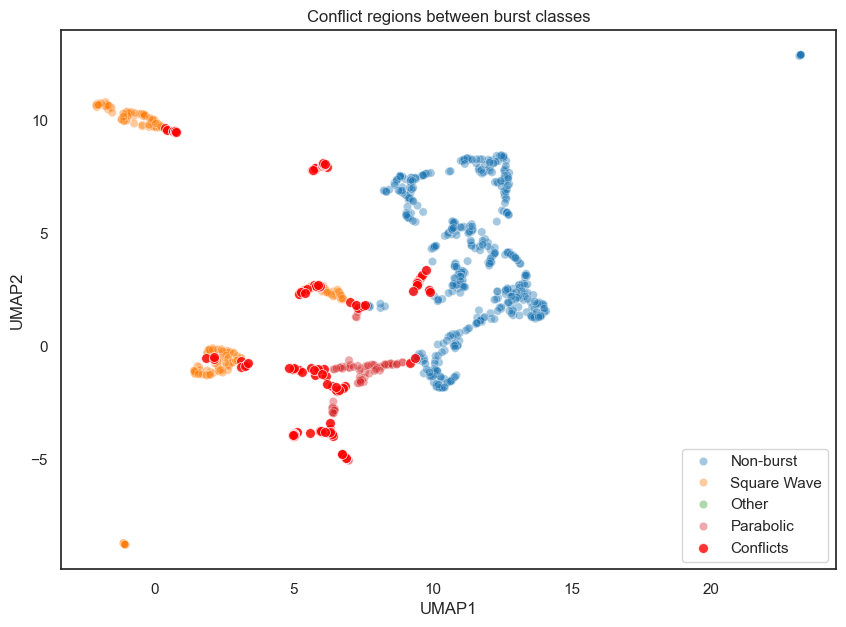

In [ ]:



# 5. Interactive Dash dashboard
app = Dash(__name__)
app.layout = html.Div([
    html.H2("Interactive Explorer: UMAP + Bursts"),
    html.P("Click a point to visualize its corresponding voltage trace."),

    # UMAP scatter plot
    dcc.Graph(
        id="umap",
        figure=px.scatter(
            df_umap,
            x="UMAP1",
            y="UMAP2",
            color="Burst_Type",
            hover_data=["id","Burst_Type"],
            custom_data=["id"],
            title="UMAP of segments"
        )
    ),

    # Voltage trace viewer
    dcc.Graph(id="timeseries")
])

# Callback function: update voltage trace plot when UMAP point clicked
@app.callback(
    Output("timeseries","figure"),
    Input("umap","clickData")
)
def display_timeseries(clickData):
    if clickData is None:
        fig = go.Figure()
        fig.update_layout(title="Click a point to view its burst trace")
        return fig

    burst_id = clickData["points"][0]["customdata"][0]  # Get selected segment ID
    y = np.array(all_segment_traces[int(burst_id)])     # Extract voltage trace
    t = np.linspace(0, len(y)/fs, len(y))              # Time axis

    # Plot selected segment
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=t, y=y, mode="lines", name=f"Segment {burst_id}"))
    fig.update_layout(
        title=f"Time series of segment {burst_id}",
        xaxis_title="Time (s)",
        yaxis_title="Voltage (mV)"
    )
    return fig

# Run the interactive dashboard
if __name__ == "__main__":
    app.run(debug=True)

- **Libraries and initial configuration:**

os: directory listing and path construction. Used when enumerating .abf files.

pyabf: domain-specific reader for ABF electrophysiology files, provides sweeps, time vectors, and voltage arrays.

numpy/pandas: core numerical and tabular data manipulation libraries. pandas will later be used to build a table of segment metrics and save it as CSV.

scipy.stats.skew, kurtosis: compute sample skewness and kurtosis for voltage segments or derivative signals, these are shape descriptors of distributions.

scipy.signal.find_peaks: detects local maxima subject to constraints (height, distance, etc.). hilbert computes the analytic signal; its magnitude is the envelope used for symmetry measures.

numpy.linalg.lstsq: least-squares polynomial fit (used to fit a second-degree polynomial to bursts to assess parabolic shape).

sklearn.metrics.r2_score: R² goodness-of-fit for polynomial fits, helps judge how well a parabola fits the burst waveform.

StandardScaler + umap: standardize numeric features and reduce feature dimensionality to 2D for visualization and clustering.

scipy.spatial.distance: compute pairwise distances between centroids of burst types (in UMAP space).

NearestNeighbors: find local neighbors for each embedded point to detect mixed-type neighborhoods (conflicts).

fastdtw.fastdtw: fast approximation of Dynamic Time Warping (DTW) to align time series with different lengths or local time-warping, used to compare burst shapes robustly.

pearsonr: Pearson correlation (used on DTW-aligned traces).

joblib.Parallel, delayed: parallelize repeated DTW/correlation computations across CPU cores.

matplotlib / seaborn / plotly / dash: plotting and interactive dashboard components. 

pio.renderers.default = "browser" forces plotly to open in a browser.

In [ ]:
# Libraries

# Import all required packages for data analysis, signal processing, visualization, and the interactive dashboard.

import os                          # For handling directories and file paths
import pyabf                       # For reading Axon Binary Files (.abf) used in electrophysiology
import numpy as np                 # Numerical operations and array handling
import pandas as pd                # Data manipulation and exporting to CSV
from scipy.stats import skew, kurtosis   # Statistical metrics for signal analysis
from scipy.signal import find_peaks, hilbert  # Peak detection and Hilbert transform for envelope analysis
from numpy.linalg import lstsq     # Least-squares fitting for curve approximation
from sklearn.metrics import r2_score   # To compute R² goodness-of-fit for polynomial fitting
from sklearn.preprocessing import StandardScaler  # For normalization before dimensionality reduction
import umap                        # Uniform Manifold Approximation and Projection for dimensionality reduction

from scipy.spatial import distance             # To compute distances between centroids in UMAP space
from sklearn.neighbors import NearestNeighbors # To find neighboring points in embedding space

from fastdtw import fastdtw        # Fast Dynamic Time Warping for time-series alignment
from scipy.stats import pearsonr    # Correlation coefficient
from joblib import Parallel, delayed # Parallelization utilities for multi-core computation

import matplotlib.pyplot as plt     # Plotting and visualization
import seaborn as sns               # Statistical plotting style
sns.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

# Libraries for interactive web-based visualization (Dash + Plotly)
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"  # Force Plotly to open figures in browser

- **Parameters and storage containers:**

folder_path: input folder containing the ABF recordings.

threshold: voltage (in mV) above which a local maximum is considered a candidate spike. Choosing this value usually requires domain knowledge or inspection of traces.

burst_threshold: maximum ISI (in seconds) for grouping spikes into the same burst. If the time between two consecutive spikes is below this threshold they are considered in the same burst.

fs and dt: the recording sampling frequency and its reciprocal used to convert between indices and time.

min_spikes_in_burst: avoids small random groups being classified as bursts (tunable).

n_jobs: number of parallel workers when computing DTW-based similarity measures — speeds up expensive pairwise work.

all_segment_metrics/all_segment_traces: lists that accumulate per-segment computed metrics and the raw waveform snippet for later saving, analysis and visualization.

abf_files: list of ABF filenames in the target folder. The script iterates over these.

In [ ]:
# 1. Parameters
# Define analysis parameters and constants used throughout the script.

folder_path = "bursting"   # Directory containing .abf electrophysiological data files
threshold = -35            # Voltage threshold (mV) for spike detection
burst_threshold = 0.3      # Maximum interspike interval (s) to group spikes into a burst
fs = 10000                 # Sampling frequency (Hz)
dt = 1 / fs                # Sampling interval (s)
min_spikes_in_burst = 4    # Minimum number of spikes required to classify as a burst
n_jobs = 4                 # Number of parallel jobs for DTW computation

# Lists to store computed metrics and segment traces
all_segment_metrics = []
all_segment_traces = []

# Get all .abf files in the target folder
abf_files = [f for f in os.listdir(folder_path) if f.endswith(".abf")]

- **ABF processing loop: reading sweeps, spike detection, burst detection, segmentation:**

Explanation (detailed):

File and sweep handling

For each ABF file, iterate through each sweep using abf.sweepCount.

abf.setSweep(sweep) updates abf.sweepX (time) and abf.sweepY (voltage).

Spike detection

find_peaks(voltage, height=threshold) returns indices of local maxima that exceed the specified threshold. It’s a simple amplitude-based spike detector — robust but may require pre-filtering in noisy traces.

spike_times = peaks / fs converts index to seconds.

Burst detection

Compute ISIs: isi = np.diff(spike_times).

A running current_burst list is used: append consecutive spikes while their ISI < burst_threshold.

When ISI exceeds burst_threshold, the current burst is closed and saved if it meets min_spikes_in_burst; then a new candidate burst begins.

After looping, the final current_burst is checked and appended if valid.

Output: bursts is a list of (start_time, end_time) for each burst.

Segment construction

Each burst becomes a ("Burst") segment.

Non-burst gaps before the first burst, between bursts, and after the last burst are added as ("Non-burst") segments to ensure full coverage of the sweep.

If no bursts are detected, the entire sweep is a single Non-burst segment.

This structure — spikes → ISIs → bursts → segments — sets the stage for per-segment analyses.


- **Burst classification:**

For each burst segment you:

Extract the voltage snippet for the burst using seg_mask.

Compute baseline estimate: mean voltage of inter-burst windows immediately before and after the burst (prev_mean, next_mean) and inter_mean is the mean of these neighbors (ignores NaNs).

burst_min = np.min(seg_voltage): the minimum voltage inside the burst — used relative to baseline to judge whether the burst is a dip (parabolic) or a plateau/flat-high (square).

Fit a second-degree polynomial y = a*t^2 + b*t + c to the burst waveform:

Use a normalized time vector t_fit spanning [-0.5, 0.5] to avoid scale issues across bursts of different durations.

lstsq returns best-fit coefficients; r2_parabola measures how well a parabola explains the waveform.

A high R² suggests a parabolic shape — but the code also uses burst_min vs inter_mean for the final classification.

Compute envelope symmetry using the Hilbert transform:

analytic_signal = hilbert(seg_voltage) — the complex analytic signal.

envelope = abs(analytic_signal) — the amplitude envelope.

Split the envelope into first and second half, reverse the second half and compute correlation to obtain a symmetry measure. Values near 1 mean symmetric rise/fall.

Count peaks inside the burst (seg_peaks) to compute spike_rate.

Classification rule (explicit):

If baseline neighbors are not available → Other.

If burst_min > inter_mean → Square Wave (burst waveform sits above local baseline; interpreted as a plateau or square-like high-voltage zone).

If burst_min < inter_mean → Parabolic (burst dives below baseline; interpreted as curved dip).

Else → Other.


- **Segment metrics computation and storage:**



For every segment (burst or non-burst) you compute a standard set of features for downstream analysis:

duration: segment length in seconds.

num_peaks: number of detected peaks inside the segment (may be 0 for non-burst).

mean_isi: average ISI among the segment peaks (0 if fewer than 2 peaks).

Statistical features of the raw voltage segment:

mean_val, std_val, min_val, max_val: central tendency and dispersion.

skew_val and kurt_val: shape-of-distribution descriptors helpful in UMAP clustering.

area_val: trapezoidal area under the voltage curve — can indicate charge/integrated depolarization.

Derivative features (first difference divided by dt) capture rate-of-change information:

mean_d, std_d, min_d, max_d, skew_d, kurt_d — these describe waveform dynamics.

In [ ]:
# 2. ABF Processing Loop
# This section reads each ABF file, extracts voltage recordings,
# detects spikes and bursts, segments the data, and calculates statistical features.

for file_name in abf_files:
    file_path = os.path.join(folder_path, file_name)
    abf = pyabf.ABF(file_path)  # Load the ABF file

    # Iterate over all sweeps (recording segments) in the ABF file
    for sweep in range(abf.sweepCount):
        abf.setSweep(sweep)
        time = abf.sweepX       # Time vector (seconds)
        voltage = abf.sweepY    # Voltage trace (mV)

        # Spike detection 
        # Detect peaks above the defined threshold.
        peaks, _ = find_peaks(voltage, height=threshold)
        spike_times = peaks / fs  # Convert sample indices to time (s)

        # Burst detection 
        # Identify groups of spikes that occur close together in time.
        bursts = []
        if len(spike_times) >= min_spikes_in_burst:
            isi = np.diff(spike_times)   # Compute interspike intervals (ISIs)
            current_burst = [spike_times[0]]

            for i in range(1, len(spike_times)):
                # If the ISI is below the burst threshold, continue the same burst
                if isi[i-1] < burst_threshold:
                    current_burst.append(spike_times[i])
                else:
                    # End the burst if ISI is too large
                    # Save only if burst meets minimum spike count
                    if len(current_burst) >= min_spikes_in_burst:
                        bursts.append((current_burst[0], current_burst[-1]))
                    current_burst = [spike_times[i]]

            # Check the last burst segment
            if len(current_burst) >= min_spikes_in_burst:
                bursts.append((current_burst[0], current_burst[-1]))

        # Define signal segments
        # Create labeled segments: "Burst" or "Non-burst" intervals
        segments = []
        for start, end in bursts:
            segments.append((start, end, "Burst"))

        # Add non-burst intervals between and around bursts
        if bursts:
            if bursts[0][0] > time[0]:
                segments.insert(0, (time[0], bursts[0][0], "Non-burst"))
            for i in range(len(bursts) - 1):
                segments.append((bursts[i][1], bursts[i + 1][0], "Non-burst"))
            if bursts[-1][1] < time[-1]:
                segments.append((bursts[-1][1], time[-1], "Non-burst"))
        else:
            segments.append((time[0], time[-1], "Non-burst"))

        # Burst classification
        # Determine whether each burst looks like a "Square Wave" or "Parabolic"
        burst_types = []
        for i, (seg_start, seg_end, seg_type) in enumerate(segments):
            if seg_type == "Burst":
                seg_mask = (time >= seg_start) & (time <= seg_end)
                seg_voltage = voltage[seg_mask]

                # Compute mean voltage in inter-burst regions before and after
                prev_mean = np.nan
                next_mean = np.nan
                if i > 0:
                    prev_end = segments[i - 1][1]
                    inter_mask_prev = (time > prev_end) & (time < seg_start)
                    if np.any(inter_mask_prev):
                        prev_mean = np.mean(voltage[inter_mask_prev])
                if i < len(segments) - 1:
                    next_start = segments[i + 1][0]
                    inter_mask_next = (time > seg_end) & (time < next_start)
                    if np.any(inter_mask_next):
                        next_mean = np.mean(voltage[inter_mask_next])
                inter_mean = np.nanmean([prev_mean, next_mean])

                # Minimum voltage within the burst
                burst_min = np.min(seg_voltage)

                # Fit a parabola to evaluate curvature (for parabolic shape detection)
                t_fit = np.linspace(-0.5, 0.5, len(seg_voltage))
                X = np.vstack([t_fit**2, t_fit, np.ones_like(t_fit)]).T
                coef, *_ = lstsq(X, seg_voltage, rcond=None)
                y_hat = X @ coef
                r2_parabola = r2_score(seg_voltage, y_hat)

                # Hilbert transform for envelope symmetry measurement
                analytic_signal = hilbert(seg_voltage)
                envelope = np.abs(analytic_signal)
                half = len(envelope) // 2
                symmetry = (
                    np.corrcoef(envelope[:half], envelope[-half:][::-1])[0, 1]
                    if half >= 2 else np.nan
                )

                # Count number of peaks in burst and estimate spike rate
                seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
                spike_rate = len(seg_peaks) / (seg_end - seg_start)

                # Classify burst type based on voltage morphology
                if np.isnan(inter_mean):
                    burst_type = "Other"
                elif burst_min > inter_mean:
                    burst_type = "Square Wave"
                elif burst_min < inter_mean:
                    burst_type = "Parabolic"
                else:
                    burst_type = "Other"
            else:
                burst_type = "Non-burst"

            burst_types.append(burst_type)

        # Segment metrics
        # Compute quantitative features for each segment for later analysis.
        for j, (seg_start, seg_end, seg_type) in enumerate(segments):
            seg_mask = (time >= seg_start) & (time <= seg_end)
            seg_voltage = voltage[seg_mask]

            duration = seg_end - seg_start
            burst_type = burst_types[j]

            seg_peaks, _ = find_peaks(seg_voltage, height=threshold)
            num_peaks = len(seg_peaks)
            mean_isi = np.mean(np.diff(seg_peaks / fs)) if num_peaks >= 2 else 0

            # Compute basic statistical measures of the voltage trace
            if len(seg_voltage) < 2:
                mean_val = std_val = min_val = max_val = skew_val = kurt_val = area_val = 0
            else:
                mean_val = np.mean(seg_voltage)
                std_val = np.std(seg_voltage)
                min_val = np.min(seg_voltage)
                max_val = np.max(seg_voltage)
                skew_val = skew(seg_voltage)
                kurt_val = kurtosis(seg_voltage)
                area_val = np.trapezoid(seg_voltage, dx=dt)

            # Compute statistics for the first derivative (dV/dt)
            if len(seg_voltage) < 2:
                mean_d = std_d = min_d = max_d = skew_d = kurt_d = 0
            else:
                deriv = np.diff(seg_voltage) / dt
                mean_d = np.mean(deriv)
                std_d = np.std(deriv)
                min_d = np.min(deriv)
                max_d = np.max(deriv)
                skew_d = skew(deriv)
                kurt_d = kurtosis(deriv)

            # Store computed metrics and raw voltage trace
            all_segment_metrics.append([
                file_name, sweep, seg_type, burst_type, duration,
                num_peaks, mean_isi,
                mean_val, std_val, min_val, max_val, skew_val, kurt_val, area_val,
                mean_d, std_d, min_d, max_d, skew_d, kurt_d
            ])
            all_segment_traces.append(seg_voltage.tolist())

- **Save results and attach raw traces to DataFrame:**


df_segments is constructed from all_segment_metrics using explicit column names.

CSV export provides a portable table that can be loaded into other tools or used for downstream analysis.

signal_array column is appended to df_segments and contains the raw waveform list for each segment. This column is necessary to display and compare raw waveforms when a user clicks a point in the dashboard or when you run DTW comparisons.

In [ ]:
# 3. Save CSV and traces
# Convert collected metrics into a DataFrame and export to CSV for external analysis.
df_segments = pd.DataFrame(all_segment_metrics, columns=[
    "File_Name", "Sweep", "Segment_Type", "Burst_Type", "Duration",
    "Num_Peaks", "Mean_ISI",
    "Mean", "Std", "Min", "Max", "Skewness", "Kurtosis", "Area",
    "Mean_Deriv", "Std_Deriv", "Min_Deriv", "Max_Deriv", "Skewness_Deriv", "Kurt_Deriv"
])
df_segments.to_csv("segment_voltage_metrics_with_ISI_and_peaks.csv", index=False)

# Add the voltage trace array to the DataFrame (used later for visualization)
df_segments["signal_array"] = all_segment_traces


- **UMAP dimensionality reduction: prepare features, standardize, embed:**

header identifies which columns are numeric features used for embedding: this selection excludes metadata columns (file name, sweep, etc.) and the signal_array.

Convert to X (numpy array) because UMAP expects a numeric matrix.

StandardScaler: centers and scales features to mean 0 and variance 1; necessary because UMAP works better when features are on comparable scales.

UMAP(n_components=2): fits a 2D nonlinear embedding that preserves local neighborhood structure — good for visualizing clustering or overlap of segment types.

df_umap stores the 2D UMAP coordinates along with Burst_Type and an id that maps back to all_segment_traces (used by the dashboard).

Index saves the original DataFrame index so you can map UMAP rows back to df_segments.


In [ ]:
# 4. UMAP dimensionality reduction
# Reduce the high-dimensional feature space to 2D for visualization and clustering.
header = list(df_segments)[4:-1]  # Select feature columns (exclude metadata and traces)
X = np.array(df_segments[header])
y = np.array(df_segments.Burst_Type)

# Standardize features to zero mean and unit variance before UMAP
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply UMAP to extract a 2D embedding
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Create DataFrame for UMAP visualization
df_umap = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
df_umap["Burst_Type"] = y
df_umap["id"] = np.arange(len(df_umap))
df_umap["Index"] = df_segments.index


- **Conflict detection in UMAP space:**

Centroids and distance matrix

Compute per-Burst_Type centroid in UMAP space — a representative center for each class.

distance.cdist calculates pairwise distances between centroids.

threshold_overlap is set to the 10th percentile of non-zero distances (a conservative rule to flag centroid pairs that are unusually close).

Nearest neighbor mixing

Build a NearestNeighbors model on UMAP coordinates with n_neighbors=8. This yields for each point the indices of its 8 nearest neighbors.

For each embedded point, check if any of its neighbors have a different Burst_Type. If so, that point is part of a mixed-type neighborhood and is flagged as a potential conflict.

Conflict DataFrame

Use the flagged indices to extract the corresponding segments from df_segments to form df_conflict. Reset index for convenience.

Add UMAP coordinates to df_conflict for plotting and neighborhood analysis.

In [ ]:
# 5. Detect conflicts between burst types
# Identify regions in UMAP space where bursts of different types overlap.
centroids = df_umap.groupby("Burst_Type")[["UMAP1", "UMAP2"]].mean()
dist_matrix = distance.cdist(centroids.values, centroids.values)
threshold_overlap = np.percentile(dist_matrix[dist_matrix > 0], 10)

# Compute nearest neighbors in UMAP space
X_umap = df_umap[["UMAP1", "UMAP2"]].values
labels = df_umap["Burst_Type"].values
nbrs = NearestNeighbors(n_neighbors=8).fit(X_umap)
distances, indices = nbrs.kneighbors(X_umap)

# Identify points that have neighbors of different types (potential conflicts)
conflict_indices = []
for i, neighbors in enumerate(indices):
    own_type = labels[i]
    neighbor_types = labels[neighbors]
    if np.any(neighbor_types != own_type):
        conflict_indices.append(df_umap.iloc[i]["Index"])

# Extract conflicting segments
df_conflict = df_segments.iloc[conflict_indices].reset_index(drop=True)
df_conflict["UMAP1"] = df_umap.iloc[conflict_indices]["UMAP1"].values
df_conflict["UMAP2"] = df_umap.iloc[conflict_indices]["UMAP2"].values

- **Shape analysis in conflict regions: DTW alignment + correlation:**

normalize(x): subtracts mean and divides by standard deviation (with a small epsilon to avoid division by zero). Normalizing signals before DTW and correlation reduces amplitude scale effects and centers comparisons on shape.

dtw_correlation(sig1, sig2):

Normalize both signals.

fastdtw(s1, s2) computes DTW distance and a warping path that aligns indices of the two signals. DTW handles local stretching/compressing in time, so pulses of different durations can be compared.

Build aligned1 and aligned2 by following the DTW path. aligned1[k] aligns to aligned2[k].

Compute Pearson correlation pearsonr(aligned1, aligned2)[0] on the DTW-aligned amplitudes — this measures how similar the shapes are after optimal local alignment.

Return DTW distance (lower means closer shape) and correlation (closer to 1 means more similar).

Neighbor structure in df_conflict:

Build a local neighbor graph among conflict points (n_neighbors=6).

For each conflict point i, compute DTW & post-alignment correlation to each neighbor j (excluding itself). Aggregated into mean DTW distance and mean correlation.

compute_similarity(i) handles missing traces defensively and returns mean DTW and mean correlation for neighbors of i.

Parallel(...)(delayed(...)) executes compute_similarity concurrently across n_jobs CPU workers for speed. The result tuple list is then unzipped into dtw_dists and corr_means.

In [ ]:
# 6. Shape analysis using DTW and correlation
# Evaluate waveform similarity within conflicting regions using Dynamic Time Warping

def normalize(x):
    # Normalize a signal to zero mean and unit variance
    x = np.array(x)
    return (x - np.mean(x)) / (np.std(x) + 1e-8)

def dtw_correlation(sig1, sig2):
    # Align two signals with DTW and compute correlation of the aligned traces
    s1, s2 = normalize(sig1), normalize(sig2)
    dist, path = fastdtw(s1, s2)
    aligned1 = np.array([s1[i] for i, j in path])
    aligned2 = np.array([s2[j] for i, j in path])
    corr = pearsonr(aligned1, aligned2)[0]
    return dist, corr

# Build neighborhood structure for conflicting bursts
embedding_conflict = df_conflict[["UMAP1", "UMAP2"]].values
nbrs_conflict = NearestNeighbors(n_neighbors=6).fit(embedding_conflict)
_, indices_conflict = nbrs_conflict.kneighbors(embedding_conflict)

def compute_similarity(i):
    #Compute average DTW distance and post-alignment correlation for each burst.
    sig_i = df_conflict.iloc[i]["signal_array"]
    if not isinstance(sig_i, (list, np.ndarray)):
        return np.nan, np.nan
    local_dtw, local_corr = [], []
    for j in indices_conflict[i, 1:]:
        sig_j = df_conflict.iloc[j]["signal_array"]
        if not isinstance(sig_j, (list, np.ndarray)):
            continue
        dist, corr = dtw_correlation(sig_i, sig_j)
        local_dtw.append(dist)
        local_corr.append(corr)
    return np.nanmean(local_dtw), np.nanmean(local_corr)

# Parallel computation for efficiency
results = Parallel(n_jobs=n_jobs)(delayed(compute_similarity)(i) for i in range(len(df_conflict)))
dtw_dists, corr_means = zip(*results)


- **Shape similarity index, visualization, and inspection of low-similarity examples:**

Construct a combined Shape Similarity Index:

Mean_DTW_Dist: average DTW distance to neighbors — normalized by max and inverted (so small DTW → high similarity).

Mean_Corr_PostDTW: average Pearson correlation after DTW alignment — normalized by its max (higher correlation → higher similarity).

The Shape_Similarity_Index is the average of the two normalized components, each weighted 0.5. This composite index ranges roughly [0,1] and balances alignment distance and correlation.

Visualization:

A UMAP scatter plot of df_conflict colored by Shape_Similarity_Index (viridis palette). High similarity appears in one color range; low similarity in another.

This plot helps identify local regions where bursts are coherent vs. where they are heterogenous.

Low similarity detection and inspection:

Define threshold_low as the 10th percentile — bursts with index below this are flagged.

Print how many such low-similarity bursts exist.

Plot up to 5 normalized waveforms from low_similarity_bursts to visually inspect the problematic waveforms. Normalization allows comparing shape independent of absolute amplitude.

In [ ]:
# Add computed shape similarity metrics to the DataFrame
df_conflict["Mean_DTW_Dist"] = dtw_dists
df_conflict["Mean_Corr_PostDTW"] = corr_means
df_conflict["Shape_Similarity_Index"] = (
    (1 - df_conflict["Mean_DTW_Dist"] / np.nanmax(df_conflict["Mean_DTW_Dist"])) * 0.5 +
    (df_conflict["Mean_Corr_PostDTW"] / np.nanmax(df_conflict["Mean_Corr_PostDTW"])) * 0.5
)

# Visualization of shape coherence
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_conflict,
    x="UMAP1", y="UMAP2",
    hue="Shape_Similarity_Index",
    palette="viridis", s=50
)
plt.title("Shape coherence in conflicting regions")
plt.legend(title="Similarity", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Identify bursts with low shape coherence
threshold_low = df_conflict["Shape_Similarity_Index"].quantile(0.1)
low_similarity_bursts = df_conflict[df_conflict["Shape_Similarity_Index"] < threshold_low]
print(f"Low-similarity conflicting bursts (<p10): {len(low_similarity_bursts)}")

# Plot a few examples of low-similarity bursts
for idx in low_similarity_bursts.index[:5]:
    sig = df_conflict.loc[idx, "signal_array"]
    plt.figure()
    plt.plot(normalize(sig))
    plt.title(f"Burst #{idx} - Shape Similarity Index = {df_conflict.loc[idx,'Shape_Similarity_Index']:.3f}")
    plt.xlabel("Normalized time")
    plt.ylabel("Normalized amplitude")
    plt.show()


- **Interactive dashboard:**

- Layout:

UMAP scatter created with plotly.express.scatter (px.scatter), color-coded by Burst_Type.

custom_data=["id"] is important: it embeds the segment id inside each plotted point so click events return a stable reference to the segment/traces.

A second plot area timeseries is a placeholder for the selected trace.

- Callback:

@app.callback(Output("timeseries","figure"), Input("umap","clickData")) registers a reactive function that redraws the time series when a point in the UMAP plot is clicked.

clickData contains details about the clicked point: clickData["points"][0]["customdata"][0] retrieves the stored id.

Defensive retrieval: use try/except to handle any mismatch (e.g., stale id, or inconsistent indexing).

Rebuild the time axis t for the saved raw trace using fs and len(y).

Add a plotly.graph_objects Scatter trace and configure the layout. hovermode="x unified" shows unified hover across the trace.

- Running:

If run as a script (__main__), starts the Dash development server with debug=True for hot reloading and detailed errors. In production you’d set debug=False.

In [ ]:
# 7. Interactive Dashboard (Dash)
# Build a web-based interface to explore UMAP clusters and inspect voltage traces.

app = Dash(__name__)
app.layout = html.Div([
    html.H2("Interactive Explorer: UMAP + Bursts"),
    html.P("Click on a point to visualize its corresponding burst trace."),

    # 2D UMAP plot with burst type coloring
    dcc.Graph(
        id="umap",
        figure=px.scatter(
            df_umap,
            x="UMAP1",
            y="UMAP2",
            color="Burst_Type",
            hover_data=["id", "Burst_Type"],
            custom_data=["id"],
            title="UMAP of voltage segments"
        )
    ),

    # Placeholder for time-series trace
    dcc.Graph(id="timeseries")
])

# Interactivity: clicking on UMAP points shows the corresponding voltage trace 
@app.callback(
    Output("timeseries", "figure"),
    Input("umap", "clickData")
)

def display_timeseries(clickData):

    # If no point was clicked, return a placeholder plot with instructions
    if clickData is None:
        fig = go.Figure()
        fig.update_layout(
            title="Click a point in the UMAP plot to view its burst waveform",
            xaxis_title="Time (s)",
            yaxis_title="Voltage (mV)"
        )
        return fig

    # Extract the customdata field that contains the 'id' we stored in df_umap
    # Plotly stores the clicked point info under clickData["points"][0]
    burst_id = clickData["points"][0]["customdata"][0]

    # Defensive check: ensure index is valid for all_segment_traces
    try:
        trace = all_segment_traces[int(burst_id)]
    except Exception:
        # If the id is invalid for any reason, return a message figure
        fig = go.Figure()
        fig.update_layout(
            title=f"Could not retrieve trace for segment id {burst_id}",
            xaxis_title="Time (s)",
            yaxis_title="Voltage (mV)"
        )
        return fig

    # Convert the saved trace into a numpy array and build a time vector
    y = np.array(trace)
    # Time axis: length(y)/fs gives total seconds; linspace includes end point so shape matches y
    t = np.linspace(0, len(y) / fs, len(y), endpoint=False)

    # Create an interactive line plot of the voltage trace
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=t,
            y=y,
            mode="lines",
            name=f"Segment {burst_id}"
        )
    )

    # Annotate plot with basic layout settings
    fig.update_layout(
        title=f"Time series of segment {burst_id} (Sweep trace)",
        xaxis_title="Time (s)",
        yaxis_title="Voltage (mV)",
        hovermode="x unified"
    )

    return fig



# Run the Dash app
if __name__ == "__main__":
    # Using debug=True during development is convenient (auto-reload, detailed errors).
    # In production or stable environments, set debug=False.
    app.run(debug=True)